<a id="Subcluster_myeloid"></a>
## Sub-cluster monocytes

- [1. Load raw data and clsutering data](#load)
- [2. Script for processing monocytes](#script)
- [3. Iterative subclustering 1 - removes clear doublets and replicating lymphocytes](#cluster_1)
- [4. Iterative subclustering 2 - removes neutrophils](#cluster_2)
- [5. Iterative subclustering 3 - removes RBCs, platelets, plasmablasts, pDCs, some doublets](#cluster_3)
- [6. Iterative subclustering 4 - remove straggler doublets](#cluster_4)
- [7. Iterative subclustering 5 - final clustering consiting only of monocytes and conventional DCs](#cluster_5)

In [1]:
import os
adir = '../../../../data/ExVivo/Seqwell'
project_name = 'exvivo2_20200318_mmul8_V4'
abase = os.path.join(adir, project_name)
gcs = False
abase

'../../../../data/ExVivo/Seqwell/exvivo2_20200318_mmul8_V4'

In [2]:
count_thresh=0
gene_thresh=300
mitothresh=.1
nhvgs = None
logstatus = 'log'

In [3]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import re

## Functions for reading files straight from google cloud storage
import sys
sys.path.append('../../../Code')
from utils import save_adata, read_adata, subcluster_iteration

import palettable
from IPython.display import display

from joblib import parallel_backend

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=80, vector_friendly=False, ipython_format='png')

np.random.seed(14)

/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex


scanpy==1.4.4.post1 anndata==0.7.1 umap==0.3.10 numpy==1.18.1 scipy==1.4.1 pandas==1.0.3 scikit-learn==0.22.2.post1 statsmodels==0.11.1 python-igraph==0.8.0 louvain==0.6.1


<a id="load"></a>

## Load raw data and previous clustering results

In [5]:
annot_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.Blacklist.HVGs_{nhvgs}.scale.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
print(annot_file)

../../../../data/ExVivo/Seqwell/exvivo2_20200318_mmul8_V4.count_0.gene_300.mito_0.1.TPT.log.Blacklist.HVGs_None.scale.h5ad


In [6]:
adata_annot = read_adata(annot_file, gcs=gcs)

Only considering the two last: ['.scale', '.h5ad'].
Only considering the two last: ['.scale', '.h5ad'].


In [7]:
adata_annot.obs['leiden_lab_group'].value_counts()

Multiplet      25650
Th             17425
B              16867
NK              8133
Tc              5694
Mono/DC         4022
Plasmablast      267
Name: leiden_lab_group, dtype: int64

In [8]:
adata_raw = sc.AnnData(adata_annot.raw.X, obs=adata_annot.obs, var=adata_annot.raw.var, uns=adata_annot.uns)
adata_raw = adata_raw[adata_raw.obs['leiden_lab_group'].isin(['Mono/DC']), :]

adata_raw_full = adata_raw.copy()

adata_raw = adata_raw[:,~(adata_raw.var['Combined_Blacklist'] | adata_raw.var['CC_Blacklist'])]
sc.pp.filter_genes(adata_raw, min_cells=10)

sc.pp.normalize_per_cell(adata_raw, counts_per_cell_after=10000)
sc.pp.log1p(adata_raw)

sc.pp.normalize_per_cell(adata_raw_full, counts_per_cell_after=10000)
sc.pp.log1p(adata_raw_full)

adata_raw.raw = adata_raw_full

filtered out 4682 genes that are detectedin less than 10 cells


Trying to set attribute `.var` of view, copying.


normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)
normalizing by total count per cell
    finished (0:00:00): normalized adata.X and added    'n_counts', counts per cell before normalization (adata.obs)


<a id="cluster_1"></a>
## Iterative subclustering 1 - removes doublets

In [9]:
genestoplot = ['CD14', 'FCGR3', 'CD3D', 'MS4A1', 'IGKC', 'CD177','log10_EBOV_TPT', 'MKI67', 'HBB', 'MAMU-DPB', 'IRF8', 'FLT3', 'MAMU-DQA1', 'PPBP']

extracting highly variable genes
    finished (0:00:01)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00)


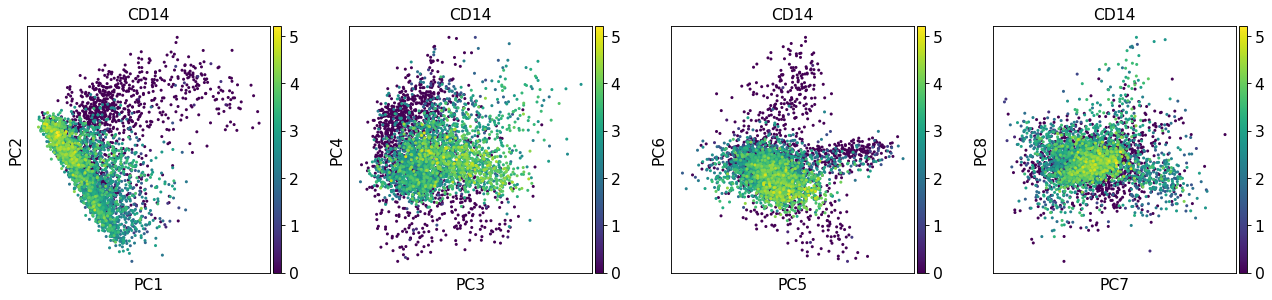

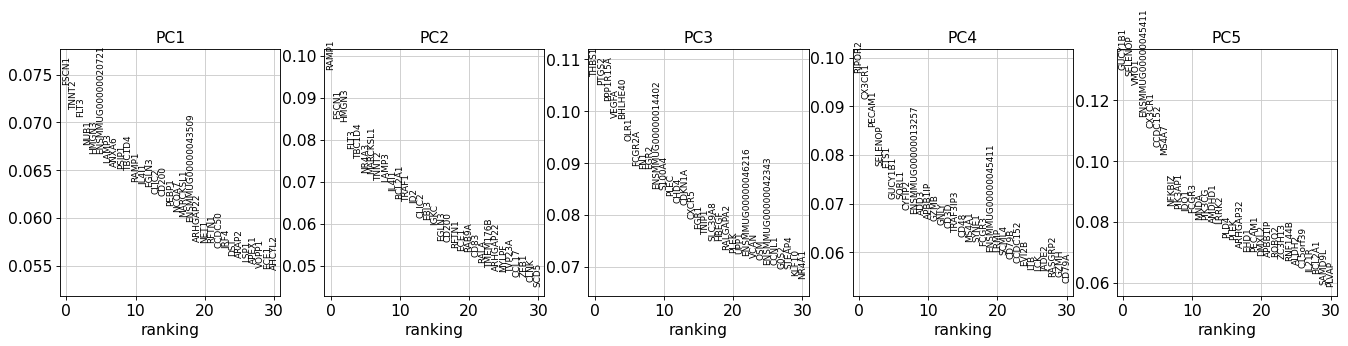

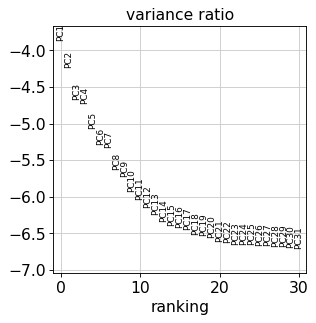

computing neighbors
    using 'X_pca' with n_pcs = 18
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:03)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:15)
running Leiden clustering
    finished: found 20 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:03)


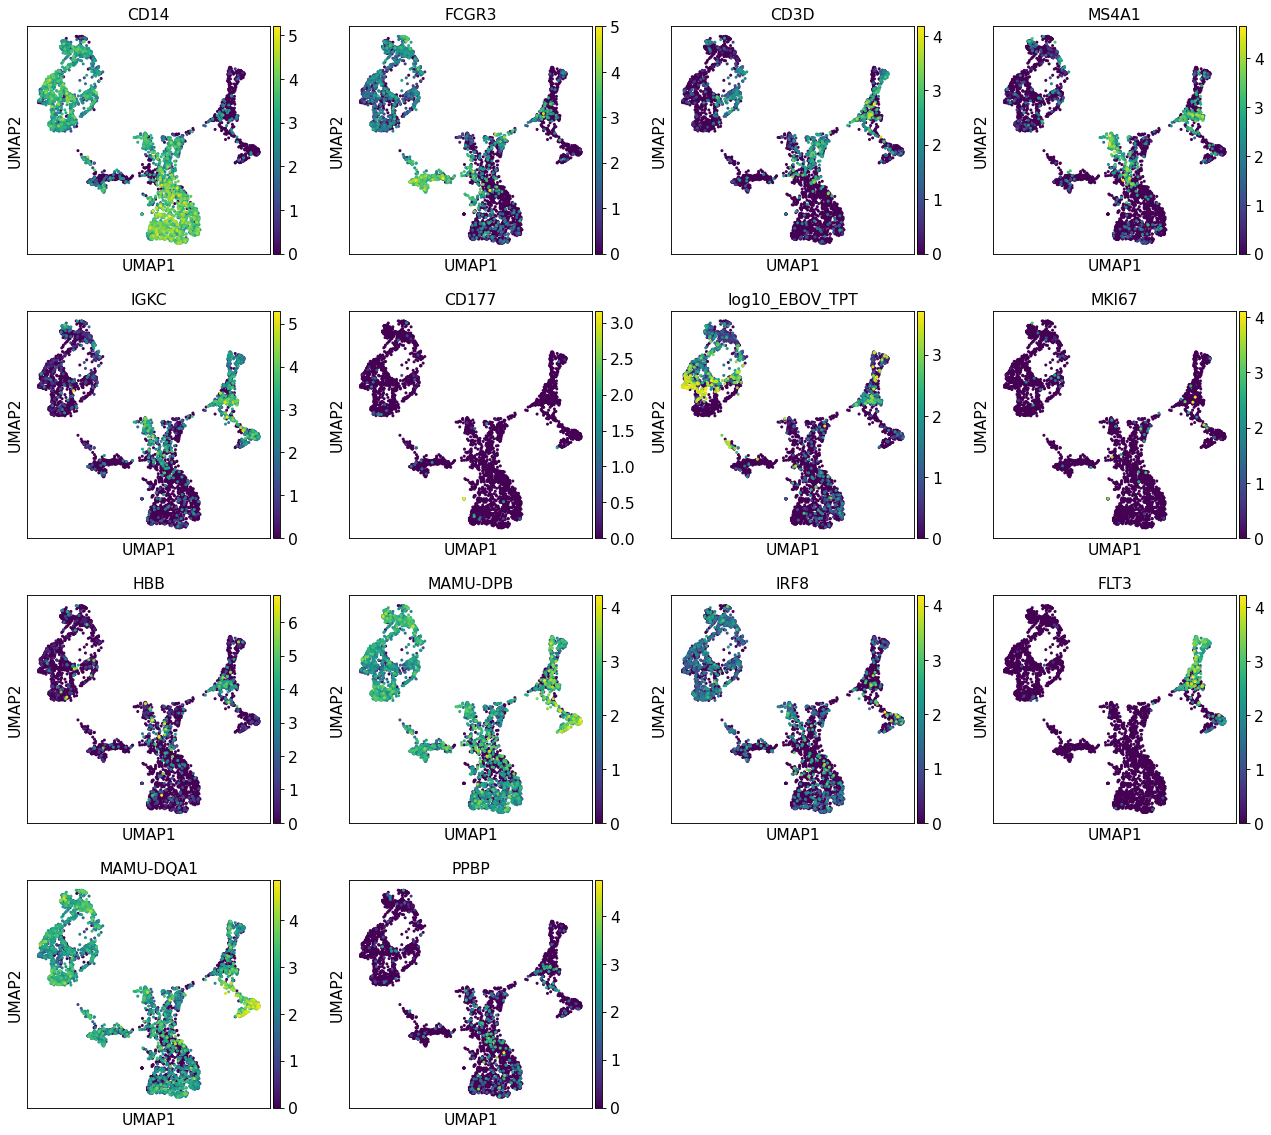

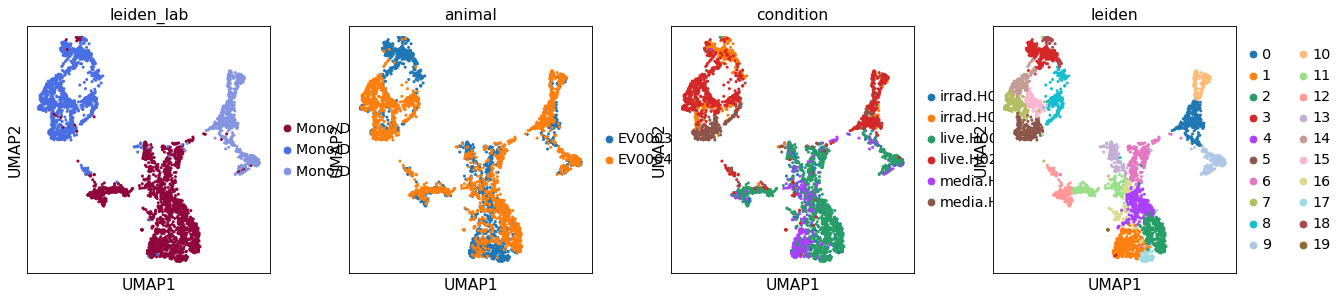

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:08)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,RPS14,FERMT3,FCGR2A,MX2,IL1B,TGFBI,ETS1,ENSMMUG00000031944,CD3D,ACTG1,FSCN1,CFD,CFD,MS4A1,ENSMMUG00000031944,LGALS3,SOD2,ANXA5,MX1,S100A9
1,ENSMMUG00000003867,PPP1R15A,PTGS2,MX1,PTGS2,STAB1,CD3D,FTL,GIMAP7,PKIB,HMGN3,LTA4H,FCGR3,CD19,LIPA,LIPA,C3AR1,RAB7B,IFIT3,S100A8
2,RPS3,CD14,IL1B,OAS2,FCGR2A,AKR1B1,SORL1,LGALS3,LIPA,HLA-DQA1,NUB1,PECAM1,LTA4H,CD79B,ENSMMUG00000012749,ENSMMUG00000031944,SLC39A8,FERMT3,HERC5,LCN2
3,TPT1,THBS1,EGR2,DDX60,SOD2,TUBA1B,RPS14,APOE,AKR1B1,MAMU-DQA1,FLT3,LYN,GUCY1B1,CD79A,UBE2L6,SDC2,LYN,PPP1R15A,MX2,GCA
4,ENSMMUG00000028701,SOD2,OLR1,ISG15,CD14,ALDH1A1,TPT1,ASAH1,ENSMMUG00000013257,CALCRL,RAMP1,MS4A7,ENSMMUG00000045411,SWAP70,AKR1B1,APOE,ENSMMUG00000042343,BHLHE40,IFIT1,CAMP
5,RPS15,NFKBIA,ANXA5,IFIT1,TPT1,MAMU-DMB,EVL,GPNMB,ALDH1A1,RAMP1,LAMP3,SELENOP,MS4A7,TCF4,PRDX1,FTL,RASGEF1B,THBS1,ISG15,RFLNB
6,RPS17L,ENSMMUG00000014402,S100A10,GIMAP4,CYP1B1,F13A1,ENSMMUG00000013257,CD36,CD2,CD83,TBC1D4,VMO1,PECAM1,IGKC,STAT1,LTA4H,IL1B,GSN,XAF1,HK3
7,RPS27A,FGR,CYP1B1,SIGLEC1,ENSMMUG00000042343,LIPA,RPL18,PLIN2,APOE,IL7R,SEC61B,ITM2B,CX3CR1,SP140,GBP2,TXN,LIMS1,A4GALT,IFIT2,SERPINB1
8,RPL23A,DMXL2,G0S2,IFIT2,ACTR2,FUCA1,GZMB,HEXB,BST2,NR4A3,RALA,FCGR3,VMO1,MEF2C,CYBB,ENSMMUG00000012749,CD83,NEK6,IFI16,GMFG
9,RPL13A,ZFP36,VEGFA,IFIT3,NFKBIA,MAMU-DMA,GIMAP7,SDC2,GIMAP4,CD58,PSIP1,GUCY1B1,SELENOP,HIP1R,GLRX,LYZ,PLEK,LMNA,OAS2,ORM1


In [10]:
adata_1 = subcluster_iteration(adata_raw, min_cells=10, nhvgs=nhvgs, npcs=18,
                        n_neighbors=30,
                        min_dist=0.1, spread=2.0,resolution=2.0,
                        umap_genestoplot=genestoplot, pc_genestoplot=['CD14'],
                        other_plot=['leiden_lab', 'animal', 'condition', 'leiden'], harmony=False,
                        scale=True)

In [11]:
adata_1.obs['leiden'].value_counts()

0     350
1     338
2     331
3     308
4     282
5     269
6     228
7     211
8     209
9     204
10    201
11    190
12    183
13    159
14    159
15    154
16    106
17     76
18     55
19      9
Name: leiden, dtype: int64

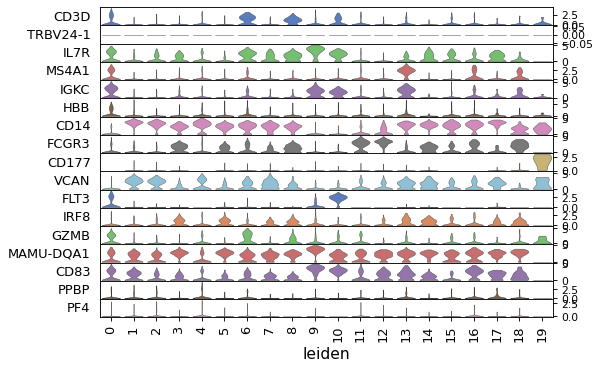

In [12]:
_ =sc.pl.stacked_violin(adata_1, var_names=['CD3D','TRBV24-1', 'IL7R', 'MS4A1', 'IGKC', 'HBB',
                                            'CD14', 'FCGR3', 'CD177', 'VCAN', 'FLT3', 'IRF8', 'GZMB', 'MAMU-DQA1', 'CD83', 'PPBP', 'PF4'], groupby='leiden', swap_axes=True)

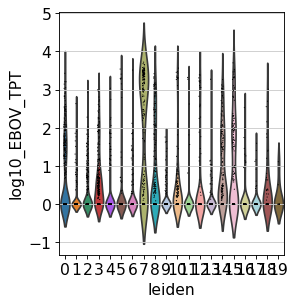

In [13]:

sc.pl.violin(adata_1, keys=['log10_EBOV_TPT'], groupby='leiden')

In [14]:
doublet_vals = ['0', '6', '8', '13', '18', '19']
doublet_ind = adata_1.obs.index[adata_1.obs['leiden'].isin(doublet_vals)]
adata_annot.obs.loc[doublet_ind, 'Doublet'] = True

<a id="cluster_2"></a>
## Iterative subclustering 2 - removes neutrophils

Trying to set attribute `.obs` of view, copying.


filtered out 532 genes that are detectedin less than 10 cells
extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes


/opt/miniconda3/envs/seqwell/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:869: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:00)


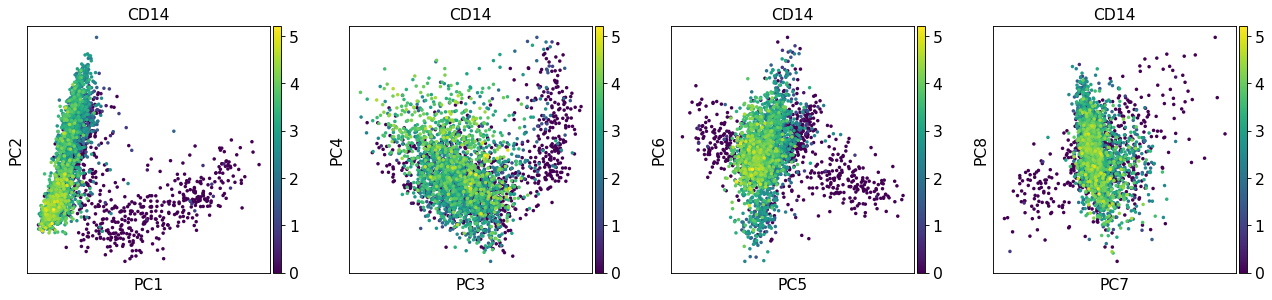

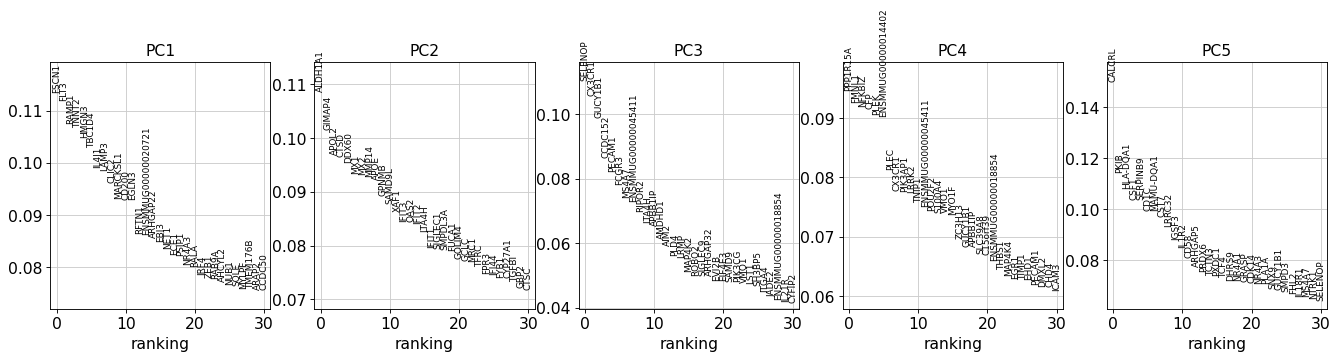

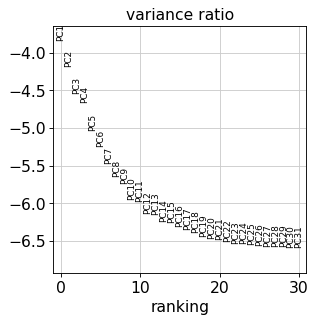

computing neighbors
    using 'X_pca' with n_pcs = 14
    finished: added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix (0:00:00)
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:10)
running Leiden clustering
    finished: found 10 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


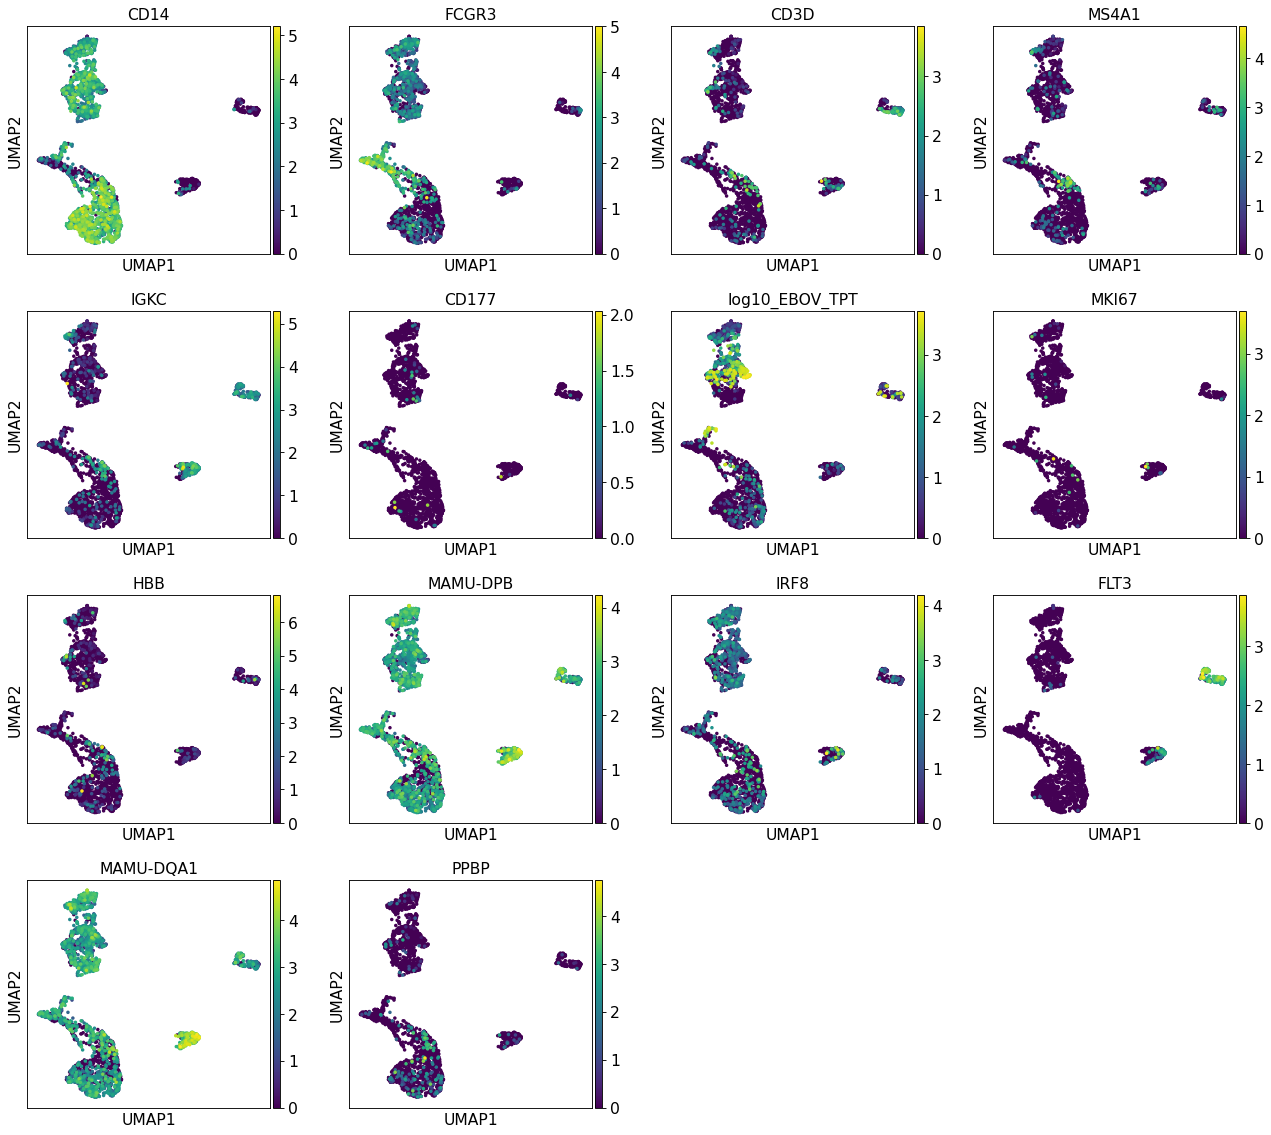

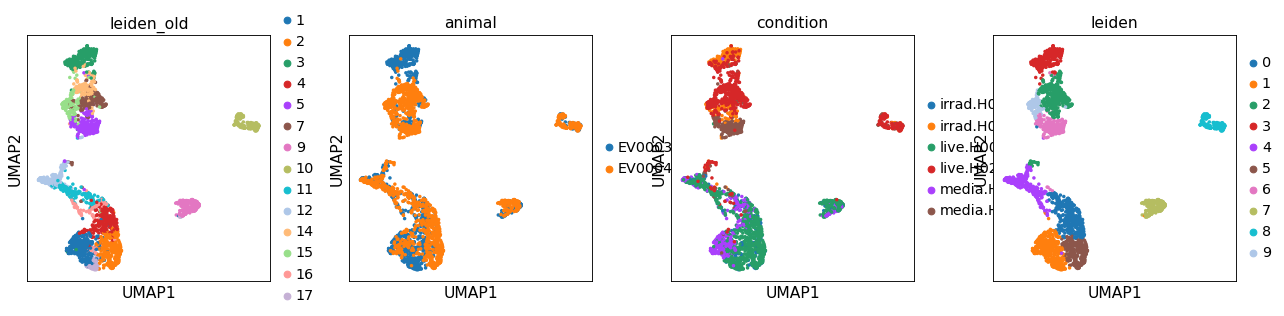

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:05)


,0,1,2,3,4,5,6,7,8,9
0,IL1B,FERMT3,ENSMMUG00000031944,MX2,CFD,FCGR2A,STAB1,ACTG1,FSCN1,LGALS3
1,TPT1,PPP1R15A,APOE,OAS2,LTA4H,PTGS2,TGFBI,PKIB,FLT3,ENSMMUG00000031944
2,PTGS2,THBS1,ENSMMUG00000012749,MX1,PECAM1,IL1B,AKR1B1,HLA-DQA1,HMGN3,SDC2
3,ENSMMUG00000028701,CD14,ADH7,DDX60,FCGR3,EGR2,F13A1,MAMU-DQA1,NUB1,LIPA
4,RPS14,ENSMMUG00000014402,PRDX1,ISG15,MS4A7,OLR1,TUBA1B,RAMP1,RAMP1,APOE
5,FCGR2A,FGR,ALDH1A1,IFIT1,LYN,ANXA5,MAMU-DMB,IL7R,LAMP3,GPNMB
6,ENSMMUG00000042343,SOD2,LIPA,IFIT2,SELENOP,VEGFA,FYB1,CALCRL,TBC1D4,ENSMMUG00000012749
7,SOD2,PLEK,FTL,GIMAP4,VMO1,UPP1,ALDH1A1,CD83,PSIP1,ENSMMUG00000041773
8,CYP1B1,NFKBIA,LGALS3,IFIT3,GUCY1B1,CYP1B1,FUCA1,ID2,SEC61B,TXN
9,DDX5,IL1B,ASAH1,SIGLEC1,ITM2B,S100A10,LIPA,NR4A3,RALA,ADH7


In [15]:
keep = adata_1.obs.index[~adata_1.obs['leiden'].isin(doublet_vals)]
Z = adata_raw[keep,:]
Z.obs['leiden_old'] = adata_1.obs.loc[keep, 'leiden']
adata_2 = subcluster_iteration(Z, min_cells=10, nhvgs=nhvgs, npcs=14,
                        n_neighbors=30,
                        min_dist=0.1, spread=2.0,resolution=1.,
                        umap_genestoplot=genestoplot, pc_genestoplot=['CD14'],
                        other_plot=['leiden_old', 'animal', 'condition', 'leiden'], harmony=False,
                        scale=True)

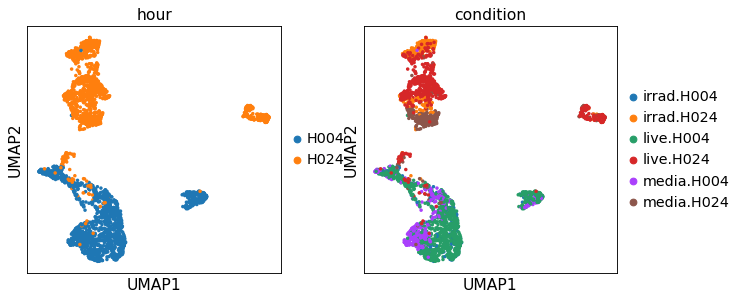

In [16]:
_ = sc.pl.umap(adata_2, color=[ 'hour','condition'])

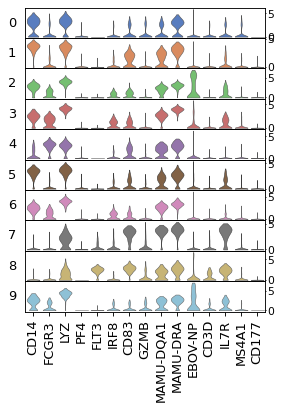

In [17]:
_ = sc.pl.stacked_violin(adata_2, var_names=[ 'CD14', 'FCGR3', 'LYZ', 'PF4', 'FLT3', 'IRF8', 'CD83', 'GZMB', 'MAMU-DQA1', 'MAMU-DRA','EBOV-NP', 'CD3D', 'IL7R', 'MS4A1', 'CD177'], groupby='leiden')

In [18]:
labmap = {'0':'Mono 1',
          '1':'Mono 2',
          '2':'Mono 3',
          '3':'Mono 4',
          '4':'Mono 5',
          '5':'Mono 6',
          '6':'Mono 7',
          '7':'cDC 1',
          '8':'cDC 2',
          '9':'Mono 8'}

... storing 'leiden_lab' as categorical
... storing 'leiden_lab_group' as categorical


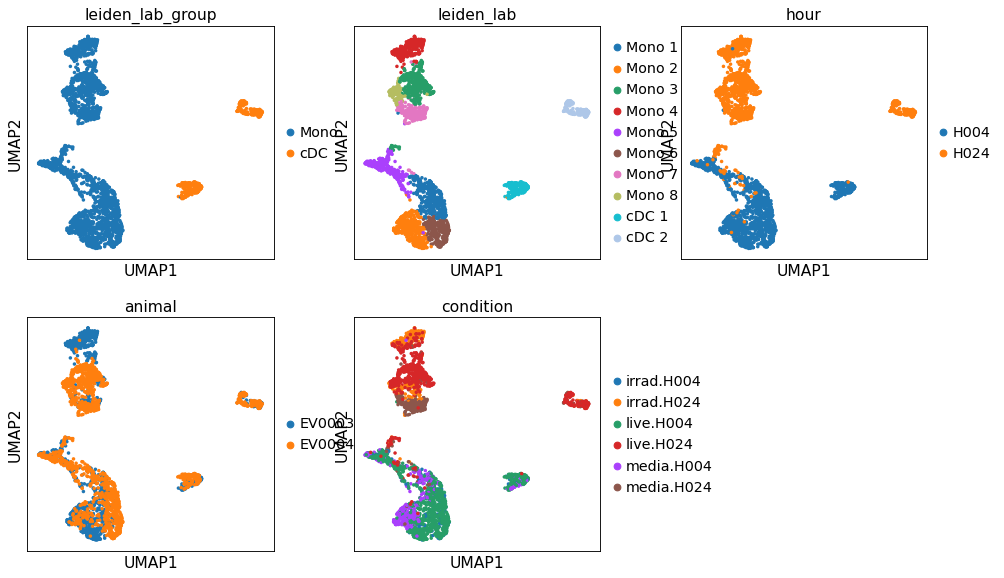

In [19]:
adata_2.obs['leiden_lab'] = adata_2.obs['leiden'].replace(labmap)
adata_2.obs['leiden_lab_group'] = adata_2.obs['leiden_lab'].apply(lambda x: x.split(' ')[0])

sc.pl.umap(adata_2, color=['leiden_lab_group', 'leiden_lab', 'hour', 'animal', 'condition'], ncols=3)

In [20]:
adata_annot.obs.loc[:, 'Subclustering'] = adata_annot.obs.loc[:, 'Subclustering'].astype(str)
adata_annot.obs.loc[:, 'SubclusteringGroup'] = adata_annot.obs.loc[:, 'SubclusteringGroup'].astype(str)


adata_annot.obs.loc[adata_2.obs.index, 'Subclustering'] = adata_2.obs['leiden_lab'] 
adata_annot.obs.loc[adata_2.obs.index, 'SubclusteringGroup'] = adata_2.obs['leiden_lab_group']

In [21]:
results_file = os.path.join(adir, '{project}.count_{count}.gene_{gene}.mito_{mito}.TPT.{log}.Blacklist.HVGs_{nhvgs}.scale.SubclusterM.h5ad'.format(project=project_name, count=count_thresh, gene=gene_thresh, mito=mitothresh, nhvgs=nhvgs, log=logstatus))
save_adata(adata_annot, results_file, gcs=gcs)

Only considering the two last: ['.SubclusterM', '.h5ad'].
Only considering the two last: ['.SubclusterM', '.h5ad'].


... storing 'Subclustering' as categorical
... storing 'SubclusteringGroup' as categorical


In [22]:
pd.crosstab([adata_annot.obs['leiden_lab_group'], adata_annot.obs['Doublet']], adata_annot.obs['SubclusteringGroup'])

SubclusteringGroup        Mono  cDC    nan
leiden_lab_group Doublet                  
B                False       0    0  16867
Mono/DC          False    2606  406      0
                 True        0    0   1010
Multiplet        False       0    0  25650
NK               False       0    0   8133
Plasmablast      False       0    0    267
Tc               False       0    0   5694
Th               False       0    0  17425